In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import tensorflow_hub as hub

Constantes a definir

In [2]:
RUTA = "./tfg_dataset"
DIM = 224
BATCH_SIZE = 32
VALIDATION_SPLIT = .2

Funciones para visualizar un ejemplo del dataset creado con image_dataset_from_directory y con flow_from_directory

In [23]:
def sample_ds_dfd(ds): 
    for i, (img, label) in enumerate(ds.take(9)): 
        plt.subplot(3, 3, i + 1)
        plt.imshow(img[0].numpy().astype("uint8"))
        plt.title(ds.class_names[np.argmax(label)])
        plt.axis("off")

def sample_ds_ffd(ds): 
    for i, (img, label) in enumerate(zip(ds[0][0], ds[0][1])):
        if i == 9: break
        plt.subplot(3, 3, i + 1)
        plt.title(dict(zip(ds.class_indices.values(), ds.class_indices.keys()))[np.argmax(label)])
        plt.imshow(img)
        plt.axis("off")

Se crea un dataset con todas las imágenes del directorio. Se elige un tamaño de batch, pero al entrenar se puede especificar otro (utiliza el menor de los dos)

In [4]:
x_train, x_val = image_dataset_from_directory(
    directory = RUTA,
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    validation_split = VALIDATION_SPLIT,
    subset = "both",
    seed = 123
)

Found 624 files belonging to 5 classes.
Using 500 files for training.
Using 124 files for validation.


Se muestran algunos ejemplos del dataset

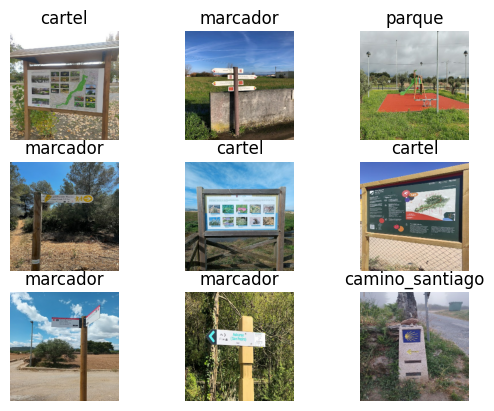

In [5]:
sample_ds_dfd(x_train)

Creamos un modelo basado en uno ya entrenado de TensorHub

In [6]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
red_hub = tf.keras.Sequential([
    hub.KerasLayer(url, input_shape = (DIM, DIM, 3), trainable = False),
    tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
])
red_hub.summary()
red_hub.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________



Entrenamos el modelo

In [7]:
%load_ext tensorboard
red_hub.fit(x_train, epochs = 25, validation_data = x_val, callbacks = [TensorBoard(log_dir = "logs")])

Epoch 1/25



16/16 [==============================] - 9s 295ms/step - loss: 1.5908 - accuracy: 0.3500 - val_loss: 1.3848 - val_accuracy: 0.4758
Epoch 2/25
16/16 [==============================] - 5s 260ms/step - loss: 1.1295 - accuracy: 0.5600 - val_loss: 1.0917 - val_accuracy: 0.6129
Epoch 3/25
16/16 [==============================] - 5s 257ms/step - loss: 0.9612 - accuracy: 0.6840 - val_loss: 1.0553 - val_accuracy: 0.6290
Epoch 4/25
16/16 [==============================] - 5s 255ms/step - loss: 0.8671 - accuracy: 0.7000 - val_loss: 0.9400 - val_accuracy: 0.6694
Epoch 5/25
16/16 [==============================] - 5s 256ms/step - loss: 0.7782 - accuracy: 0.7240 - val_loss: 0.8754 - val_accuracy: 0.7016
Epoch 6/25
16/16 [==============================] - 5s 255ms/step - loss: 0.7268 - accuracy: 0.7460 - val_loss: 0.8688 - val_accuracy: 0.7258
Epoch 7/25
16/16 [==============================] - 5s 254ms/step - loss: 0.6797 - accuracy: 0.7560 - val_loss: 0.8315 - val_accuracy: 0.7097
Epoch 8/25
16/16 

Hacemos algunas predicciones para probar (habría que separar datos de test que no haya visto y probar sobre esos)

In [8]:
def sample_predict_ds_fd(ds, modelo): 
    batch = next(iter(ds.take(1)))
    for i in range(9): 
        prediccion = np.argmax(modelo.predict(np.expand_dims(batch[0][i], axis = 0))[0])
        plt.subplot(3, 3, i + 1)
        plt.title(ds.class_names[prediccion])
        plt.imshow(batch[0][i].numpy().astype("uint8"))
        plt.axis("off")

1/1 [==============================] - 0s 40ms/step


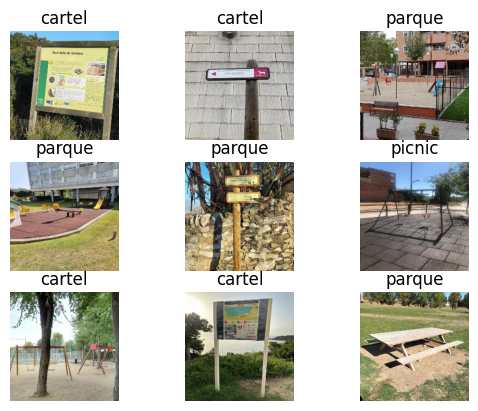

In [9]:
sample_predict_ds_fd(x_val, red_hub)

Como se podía ver durante el entrenamiento y mediante esta prueba, no termina de obtenerse un buen resultado. Se va a proceder a la técnica del aumento de datos. (Por ahora probamos a cargar con esta otra función sin modificar las imágenes). 

In [10]:
generador_original = ImageDataGenerator(
    rescale = 1/255,
    validation_split = VALIDATION_SPLIT
)

generador_modificado = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 10,
    zoom_range = [0.25, 1.25],
    rescale = 1/255,
    validation_split = VALIDATION_SPLIT
)

x_train_2 = generador_original.flow_from_directory(RUTA, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "training")

x_val_2 = generador_original.flow_from_directory(RUTA, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "validation")

x_train_au = generador_modificado.flow_from_directory(RUTA, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "training")

x_val_au = generador_modificado.flow_from_directory(RUTA, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "validation")

Found 501 images belonging to 5 classes.


Found 123 images belonging to 5 classes.
Found 501 images belonging to 5 classes.
Found 123 images belonging to 5 classes.


Se muestran las imágenes modificadas

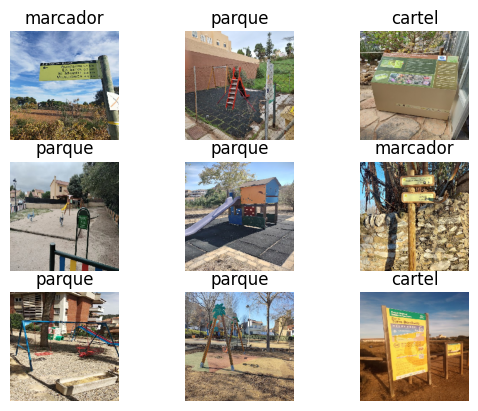

In [24]:
sample_ds_ffd(x_train_2)

Ahora se crea un modelo igual para entrenarlo y comprobar si esta técnica aporta diferencias al entrenamiento

In [25]:
red_hub_au = tf.keras.Sequential([
    hub.KerasLayer(url, input_shape = (DIM, DIM, 3), trainable = False),
    tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
])
red_hub_au.summary()
red_hub_au.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


Entrenamos el modelo

In [26]:
%load_ext tensorboard
red_hub_au.fit(x_train_2, epochs = 25, validation_data = x_val_2, callbacks = [TensorBoard(log_dir = "logs")])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/25
16/16 [==============================] - 11s 473ms/step - loss: 1.1780 - accuracy: 0.5449 - val_loss: 0.5200 - val_accuracy: 0.8537
Epoch 2/25
16/16 [==============================] - 7s 430ms/step - loss: 0.4155 - accuracy: 0.9022 - val_loss: 0.2476 - val_accuracy: 0.9431
Epoch 3/25
16/16 [==============================] - 7s 416ms/step - loss: 0.2363 - accuracy: 0.9641 - val_loss: 0.1590 - val_accuracy: 0.9512
Epoch 4/25
16/16 [==============================] - 7s 424ms/step - loss: 0.1637 - accuracy: 0.9721 - val_loss: 0.1287 - val_accuracy: 0.9593
Epoch 5/25
16/16 [==============================] - 7s 425ms/step - loss: 0.1256 - accuracy: 0.9820 - val_loss: 0.1081 - val_accuracy: 0.9675
Epoch 6/25
16/16 [==============================] - 7s 424ms/step - loss: 0.1004 - accuracy: 0.9900 - val_loss: 0.0961 - val_accuracy: 0.9593
Epoch 7/25
16/16 [==============================] - 7s 42

Se nota una mejora importante (?), vamos a hacer algunas predicciones (también habría que hacerlo sobre fotos nuevas, etc). 

In [27]:
def sample_predict_ds_ffd(ds, modelo): 
    for i, (img, label) in enumerate(zip(ds[0][0], ds[0][1])):
        if i == 9: break
        prediccion = np.argmax(modelo.predict(np.expand_dims(img, axis = 0))[0])
        plt.subplot(3, 3, i + 1)
        plt.title(dict(zip(ds.class_indices.values(), ds.class_indices.keys()))[prediccion])
        plt.imshow(img)
        plt.axis("off")

1/1 [==============================] - 0s 37ms/step


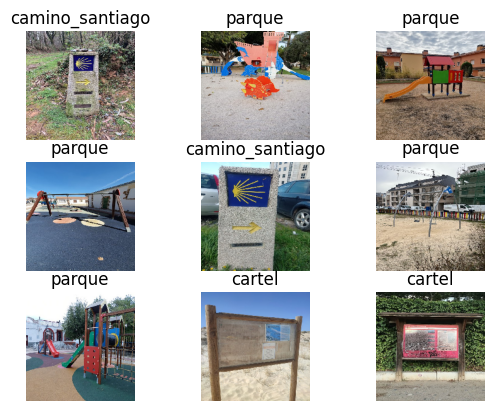

In [29]:
sample_predict_ds_ffd(x_val_2, red_hub_au)